<a href="https://colab.research.google.com/github/IlhamThrq/ComputerVision_TRK25/blob/main/Jobsheet3_Ilham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 03: TEKNIK REGRESI GAMBAR

## Praktikum D1: Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

### 1. Setup & Generator Dataset

Kita akan membuat dataset citra 64×64 berisi satu lingkaran putih di latar hitam. Tiap gambar punya radius dan titik pusat acak.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample gambar lingkaran
def make_sample(img_size=64, min_r=5, max_r=20):
    # Tentukan radius acak antara min_r dan max_r
    r = np.random.randint(min_r, max_r + 1)

    # Buat kanvas hitam ukuran (img_size x img_size)
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # Tentukan koordinat acak untuk pusat lingkaran
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    # Gambar lingkaran putih terisi penuh di atas kanvas hitam
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # Normalisasi piksel ke rentang [0, 1]
    img = (img / 255.0).astype(np.float32)

    # Ubah ke format 3-channel agar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)


### 2. "Tebak Apa??" Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

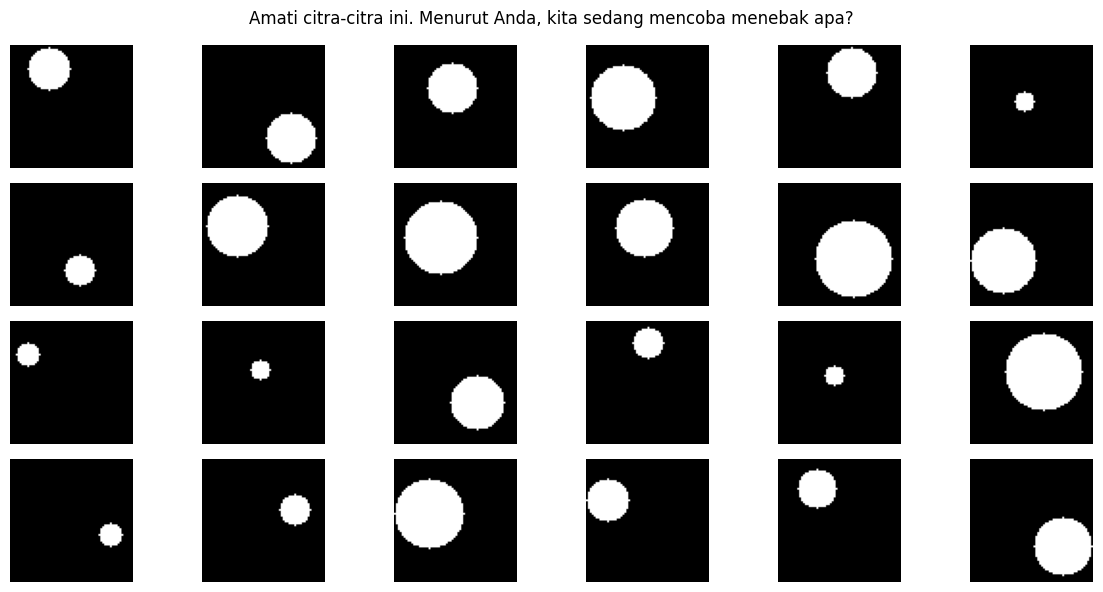

In [4]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Tampilkan grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=12)
plt.tight_layout()
plt.show()


Diskusi cepat:

*  Apakah yang berubah dari gambar ke gambar?
> JAWABAN: Yang berubah dari satu gambar ke gambar lainnya adalah ukuran lingkaran (radius) dan posisi pusatnya (cx, cy). Setiap gambar menampilkan lingkaran dengan ukuran dan lokasi acak di dalam bidang hitam.

*  Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
> JAWABAN: Ya, ukuran lingkaran dapat dinyatakan sebagai angka radius (panjang jari-jari). Nilai ini bersifat numerik dan dapat dijadikan target regresi bagi model pembelajaran mesin untuk diprediksi dari citra.

*  Apakah posisi pusat juga bisa jadi target?
> JAWABAN: Bisa. Koordinat pusat lingkaran (cx, cy) juga merupakan nilai numerik yang bisa dijadikan target tambahan, misalnya jika tujuan model adalah memprediksi lokasi objek dalam gambar selain ukurannya.


### 3. Buka Jawaban: Target yang Ingin Diprediksi


Di D1 ini, target utamanya adalah radius lingkaran (nilai kontinu). Mari ungkap labelnya di gambar yang sama

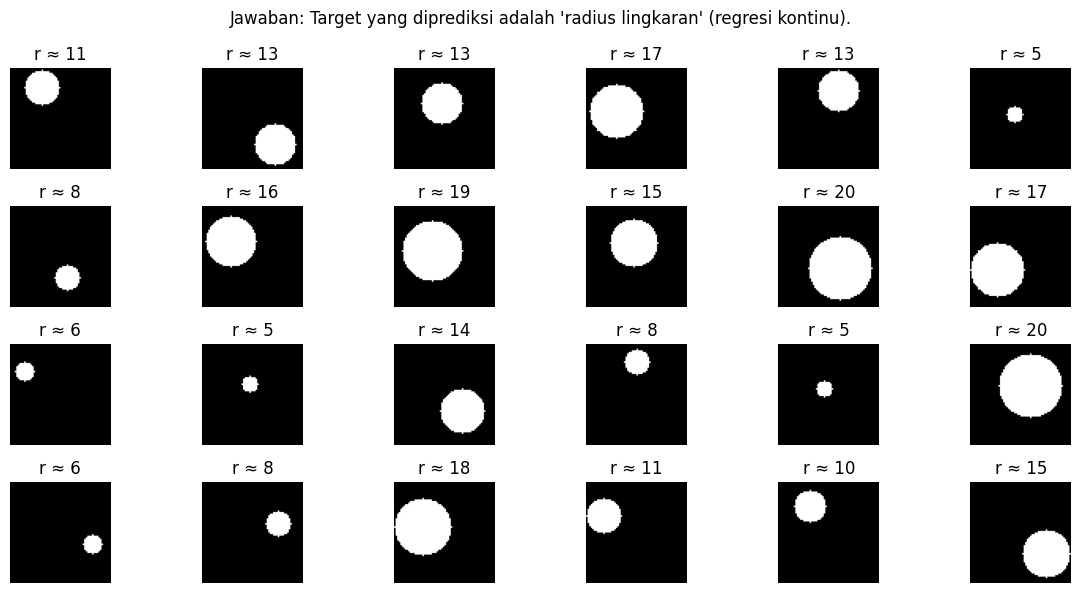

In [5]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).", fontsize=12)
plt.tight_layout()
plt.show()


### 4. Latih CNN Kecil untuk Memprediksi Radius

Kalau sudah paham “tebakannya”, mari buktikan bahwa CNN bisa mempelajari hubungan “pola lingkaran → angka radius”.

In [6]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi data menjadi train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Latih model
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi model
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MAE = 0.985 | RMSE = 1.199 | R² = 0.935


Plot history & True vs Predicted

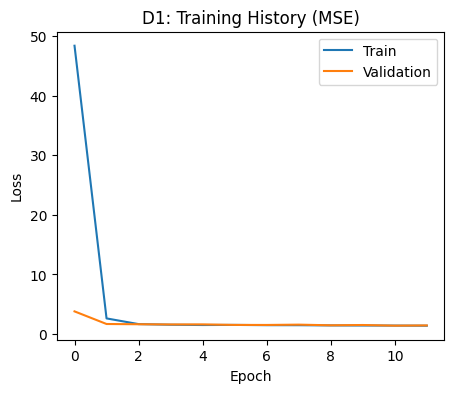

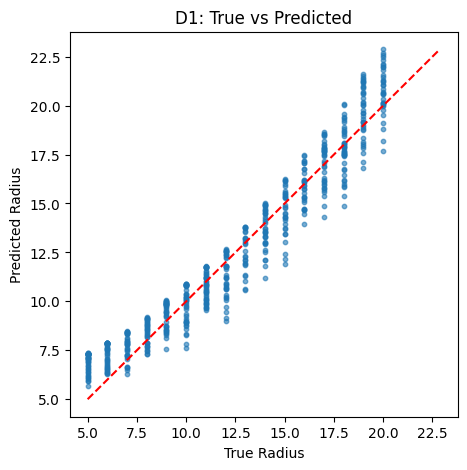

In [7]:
# Plot training & validation loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter plot: True vs Predicted radius
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


### 5. Tantangan Mini

*	Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
* Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
* Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?



=== Eksperimen 1: Rentang radius 8–28 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[Radius 8–28] MAE=1.180 | RMSE=1.434 | R²=0.937


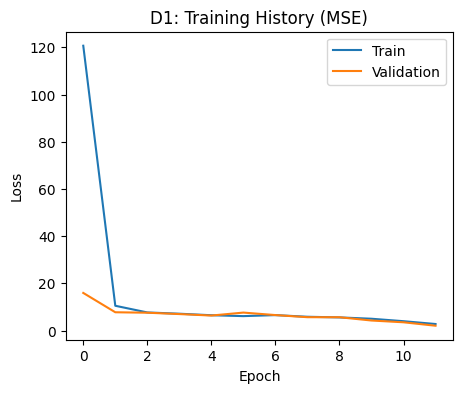

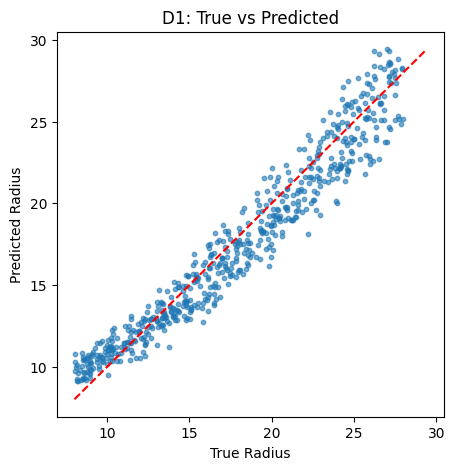


=== Eksperimen 2: Citra dengan noise ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
[Dengan Noise] MAE=1.195 | RMSE=1.513 | R²=0.932


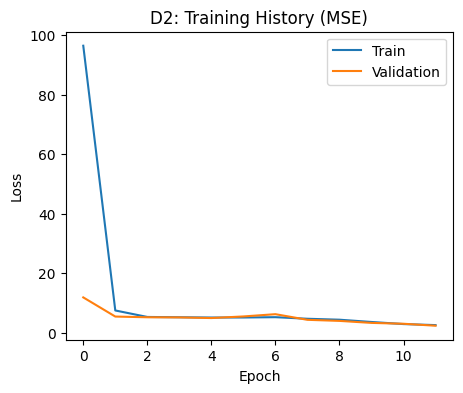

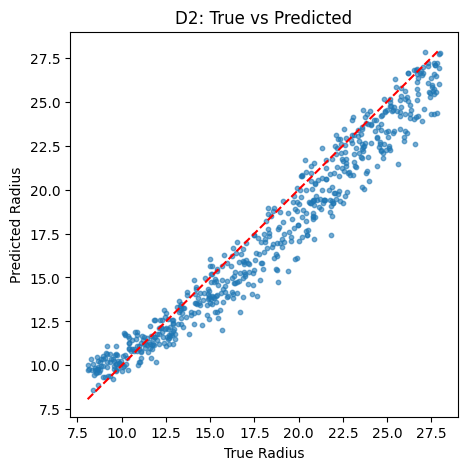


=== Eksperimen 3: Multi-output [r, cx, cy] ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[Multi-output] MAE=4.563 | RMSE=6.382 | R²=0.467


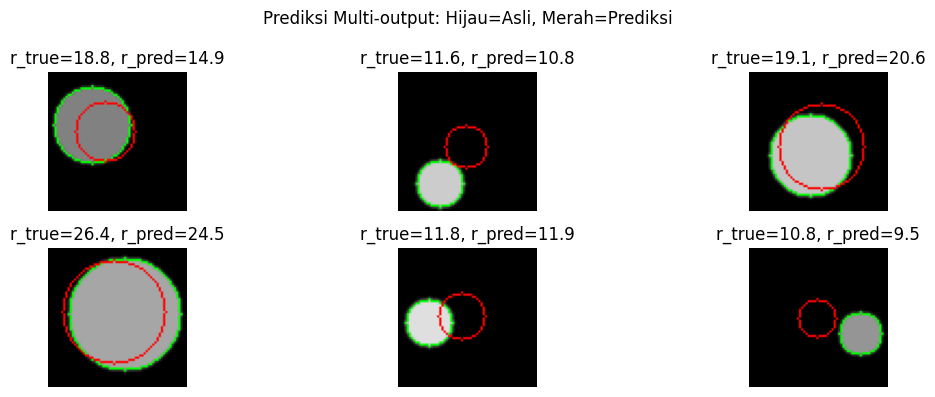

In [9]:
# ============================================================
# Tantangan Mini CNN Regresi Lingkaran + Visualisasi Lengkap
# ============================================================

# --- IMPORT LIBRARIES ---
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ============================================================
# 1. FUNGSI PEMBUAT CITRA LINGKARAN
# ============================================================
def make_sample(img_size=64, min_r=5, max_r=20):
    """Membuat satu citra berisi satu lingkaran acak."""
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    r = np.random.uniform(min_r, max_r)
    cx = np.random.uniform(r, img_size - r)
    cy = np.random.uniform(r, img_size - r)
    color = np.random.uniform(0.5, 1.0)
    cv2.circle(img, (int(cx), int(cy)), int(r), (color, color, color), -1)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img, r, (cx, cy)

# ============================================================
# 2. BASE MODEL CNN UNTUK REGRESI
# ============================================================
def make_cnn_model(output_dim=1):
    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ============================================================
# 3. FUNGSI PLOT TRAINING DAN SCATTER
# ============================================================
def plot_results(history, y_true, y_pred, title_prefix):
    # Plot training & validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"{title_prefix}: Training History (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Scatter plot True vs Predicted
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', color='red')
    plt.xlabel("True Radius")
    plt.ylabel("Predicted Radius")
    plt.title(f"{title_prefix}: True vs Predicted")
    plt.show()

# ============================================================
# 4. EKSPERIMEN 1: RENTANG RADIUS 8–28
# ============================================================
print("\n=== Eksperimen 1: Rentang radius 8–28 ===")
N = 3000
X, y, C = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Radius 8–28] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "D1")

# ============================================================
# 5. EKSPERIMEN 2: CITRA DENGAN NOISE (BLUR + GAUSSIAN)
# ============================================================
print("\n=== Eksperimen 2: Citra dengan noise ===")

def make_noisy_sample(img_size=64, min_r=8, max_r=28):
    img, r, (cx, cy) = make_sample(img_size, min_r, max_r)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    noise = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0.0, 1.0)
    return img, r, (cx, cy)

X, y, C = zip(*[make_noisy_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_cnn_model()
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Dengan Noise] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

plot_results(history, yte, y_pred, "D2")

# ============================================================
# 6. EKSPERIMEN 3: MULTI-OUTPUT [r, cx, cy]
# ============================================================
print("\n=== Eksperimen 3: Multi-output [r, cx, cy] ===")

X, y_r, centers = zip(*[make_sample(min_r=8, max_r=28) for _ in range(N)])
X = np.array(X, dtype=np.float32)
y_r = np.array(y_r, dtype=np.float32)
C = np.array(centers, dtype=np.float32)
y_multi = np.column_stack([y_r, C])  # target = [r, cx, cy]

Xtr, Xte, ytr, yte = train_test_split(X, y_multi, test_size=0.2, random_state=42)

model_multi = make_cnn_model(output_dim=3)
history = model_multi.fit(Xtr, ytr, validation_data=(Xte, yte),
                          epochs=12, batch_size=64, verbose=0)

y_pred = model_multi.predict(Xte)
mae = mean_absolute_error(yte, y_pred)
rmse = np.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"[Multi-output] MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# ============================================================
# 7. VISUALISASI MULTI-OUTPUT
# ============================================================
N_show = 6
preds = y_pred[:N_show]
imgs = Xte[:N_show]
trues = yte[:N_show]

plt.figure(figsize=(12, 4))
for i in range(N_show):
    plt.subplot(2, 3, i + 1)
    img = imgs[i].copy()
    r_t, cx_t, cy_t = trues[i]
    r_p, cx_p, cy_p = preds[i]

    # Lingkaran hijau = ground truth, merah = prediksi
    cv2.circle(img, (int(cx_t), int(cy_t)), int(r_t), (0, 1, 0), 1)
    cv2.circle(img, (int(cx_p), int(cy_p)), int(r_p), (1, 0, 0), 1)

    plt.imshow(img)
    plt.title(f"r_true={r_t:.1f}, r_pred={r_p:.1f}")
    plt.axis('off')

plt.suptitle("Prediksi Multi-output: Hijau=Asli, Merah=Prediksi", fontsize=12)
plt.tight_layout()
plt.show()


Dari eksperimen ini dapat disimpulkan bahwa:

> CNN mampu melakukan regresi kontinu untuk parameter geometris (radius, koordinat).

> Model sederhana sudah cukup akurat mengenali pola lingkaran dasar meskipun dengan noise.

> Namun, performa belum maksimal dan masih bisa ditingkatkan melalui optimasi arsitektur, data, dan skema pelatihan.

> Praktikum ini mengajarkan konsep penting:

* CNN tidak hanya untuk klasifikasi (seperti mengenali kucing/anjing), tetapi juga untuk estimasi nilai numerik dari citra.

* Model regresi visual sensitif terhadap skala input dan kompleksitas data.

* Eksperimen kecil seperti ini bisa diperluas menjadi sistem deteksi bentuk geometris atau object localization sederhana.

## Praktikum D2: Menebak Umur Manusia dari Foto Wajah (UTKFace)

### 1. Membuat akun Kaggle dan Mengunduh Kaggle.json

Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.

Ikuti langkah berikut:
> 1.	Buka situs https://www.kaggle.com
> 2.	Daftar menggunakan email Google atau GitHub.
> 3.	Setelah login, klik profil di kanan atas → pilih “Account”.
> 4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.
> 5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.
File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).




### 2. Mengunggah kaggle.json ke Colab

In [1]:
# Jalankan ini di awal notebook
from google.colab import files

# Unggah file kaggle.json dari komputer
files.upload()  # Pilih file kaggle.json secara manual


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilhamthaariq","key":"43be6ade838345c90bfeed2a75d1cf5d"}'}

In [2]:
import os
import shutil

if os.path.exists("kaggle.json"):
    # Buat folder .kaggle di home jika belum ada
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

    # Salin file kaggle.json ke folder .kaggle
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

    # Set permission file agar aman
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    # Install library kaggle
    !pip -q install kaggle

    print("Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


Kaggle API siap digunakan.


### 3. Mengunduh Dataset UTKFace dari Kaggle

In [3]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q

# Ekstrak dataset
!unzip -q /content/utkface-new.zip -d /content/utk

print("Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak.


### 4. Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


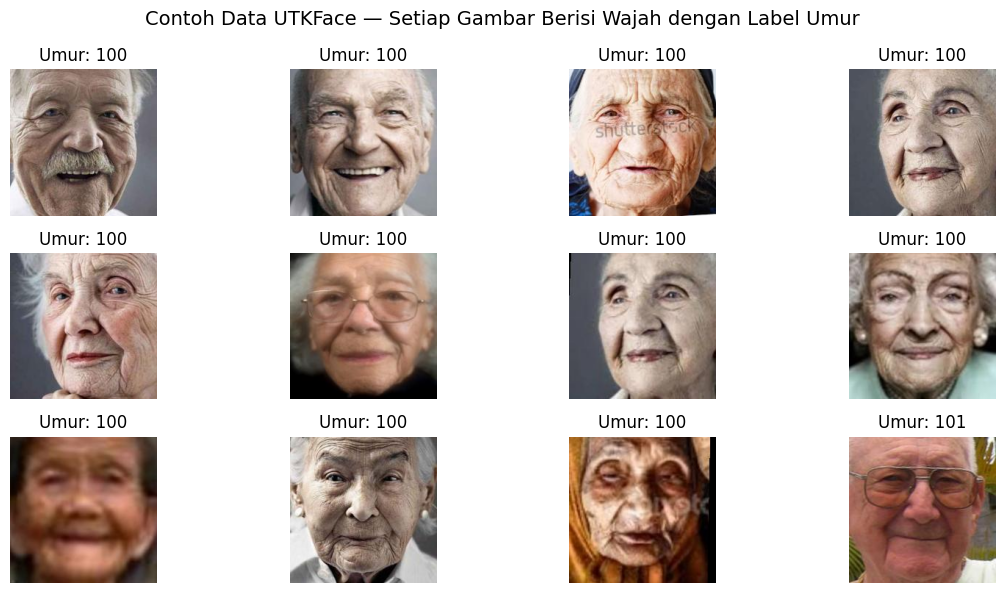

In [4]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))

for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle(
    "Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur",
    fontsize=14
)
plt.tight_layout()
plt.show()


### 5. Siapkan Dataset untuk Model

In [15]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Fungsi untuk mengambil umur dari nama file
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

# Ambil umur dari setiap file
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# Split dataset menjadi training dan testing
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# Ukuran gambar
IMG_SIZE = 224

# Fungsi untuk load dan preprocess gambar
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

# Buat dataset TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("Dataset siap dilatih.")


Dataset siap dilatih.


### 6. Membangun Model dengan Transfer Learning

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Ukuran gambar (pastikan variabel ini sudah ditentukan sebelumnya)
IMG_SIZE = 224  # contoh nilai, bisa disesuaikan

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # Tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # Output tunggal: regresi umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# Tampilkan ringkasan model
model.summary()


Hardware: GPU


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_4 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 7. Melatih Model (Tahap 1: Frozen)

Tahap pertama ini adalah pemanasan.

> Kita hanya melatih bagian head regresi, sementara backbone-nya tetap beku. Tujuannya agar bagian atas bisa “belajar membaca” fitur wajah tanpa mengganggu pengetahuan umum MobileNetV2.





Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - loss: 350.3144 - mae: 13.8801 - val_loss: 166.5949 - val_mae: 9.9605 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 162.1744 - mae: 9.6060 - val_loss: 150.9644 - val_mae: 9.3747 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 149.5235 - mae: 9.0768 - val_loss: 143.5687 - val_mae: 9.0564 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 144.5582 - mae: 8.8671 - val_loss: 140.5386 - val_mae: 8.9359 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 139.2842 - mae: 8.6672 - val_loss: 139.7264 - val_mae: 8.9340 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 139.5818 - mae: 8.6705 - val_loss: 136.0761 - val_mae: 8.7388 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - loss: 136.5508 - mae: 8.5710 - val_loss: 133.9980 - va

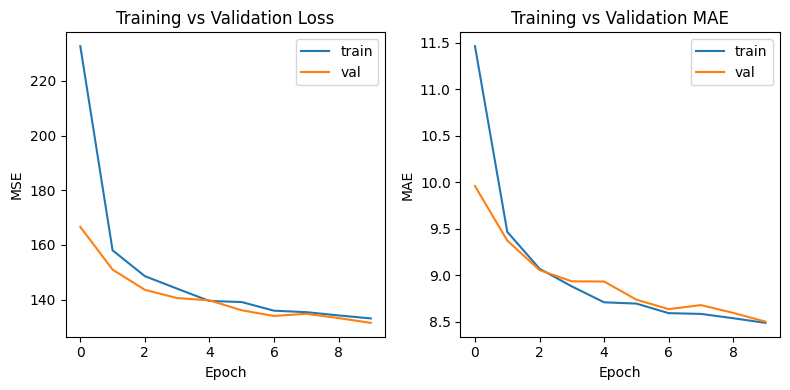

In [17]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

# Proses pelatihan model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()
